# Orthogonal Distance Regression for RSL data

This scripts calculates the residual vertical land movement starting from Common Era RSL data, once post-industrial RSL rise and GIA are taken into account. The results are then plotted together with an orthogonal distance regression that represents the crustal movement since the RSL index points were formed.

In [4]:
import pandas as pd
import numpy as np
import scipy as scipy
import scipy.odr as odr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

#Import the dataframe
RSL=pd.read_excel('Common_era.xlsx', header=0)

In [5]:
# Insert values for the calculation

#Time of Survey
ToS=2018

#Glacial Isostatic Adjustment land uplift/subsidence rates (m/yr)
GIA_avg=0.00036
GIA_sd=0.000092
RSL['GIA_corr']=GIA_avg*(RSL['Mean age [cal a BP]']+(ToS-1950))
RSL['GIA_corr_Sd']=abs(RSL['GIA_corr'])*(np.sqrt(((GIA_sd/GIA_avg)**2)+
                                                ((RSL['Error (yr)']/(RSL['Mean age [cal a BP]']+(ToS-1950)))**2)))

#post-industrial sea level rise (m)
ESL_1900=0.1848
ESL_1900SD=0.0259

#RSL corrections calculations
RSL['Corr_Elev']=RSL['RSL [m]']+ESL_1900-RSL['GIA_corr']
RSL['Corr_Elev_sd']=np.sqrt(RSL['Vertical error ± [m]']**2+ESL_1900SD**2+RSL['GIA_corr_Sd']**2)


print ('Table 1 - Sea level data used')
RSL

#Adjust column names
#gapminder.columns = ['country','year','population',
 #                    'continent','life_exp','gdp_per_cap']

Table 1 - Sea level data used


,Sample Name,Island Name,14 C age,14 C error,Mean age [cal a BP],Error (yr),Elevation [m] with respect to msl,HLC [m],RSL [m],Vertical error ± [m],GIA_corr,GIA_corr_Sd,Corr_Elev,Corr_Elev_sd
0,PS_FMA1,Suranti,490.00,30,114.0,114.0,-1.456000,-0.74,-0.534536,0.252456,0.06552,0.044324,-0.415256,0.257623
1,PS_FMA2,Suranti,560.00,30,187.5,91.5,-1.196000,-0.74,-0.144536,0.248464,0.09198,0.040467,-0.051716,0.253066
2,PS_FMA3,Suranti,620.00,30,236.5,96.5,-1.166000,-0.74,-0.114536,0.248464,0.10962,0.044628,-0.039356,0.253765
3,PT_FMA5,Tambakulu,460.00,30,95.0,95.0,-0.879699,-0.74,-0.158235,0.130897,0.05868,0.037343,-0.032115,0.138562
4,PT_FMA6,Tambakulu,490.00,30,114.0,114.0,-0.879699,-0.74,-0.158235,0.130897,0.06552,0.044324,-0.038955,0.140604
5,PT_FMA7,Tambakulu,470.00,30,112.5,112.5,-0.959699,-0.74,-0.238235,0.130897,0.06498,0.043772,-0.118415,0.140431
6,PT_FMA8,Tambakulu,106.55,0.4 pMC,36.5,11.5,-0.809699,-0.74,0.111765,0.230725,0.03762,0.010468,0.258945,0.232410
7,PT_FMA9,Tambakulu,420.00,30,58.0,58.0,-0.939699,-0.74,-0.088235,0.230725,0.04536,0.023882,0.051205,0.233399



Rate = -0.52 mm/a



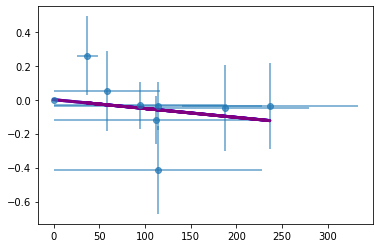

In [6]:
#Add one row to the dataframe representing MSL (not exactly zero to avoid errors)
RSL.loc[-1] = ['MSL','Modern', 0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001
               ,0.000001,0.000001,0.000001,0.000001] 
RSL.index = RSL.index + 1
RSL = RSL.sort_index()

#Define x,y and their errors including ESL and GIA corrections
xerr = np.array(RSL['Error (yr)'].values.tolist())
x = np.array(RSL['Mean age [cal a BP]'].values.tolist())
yerr = np.array(RSL['Corr_Elev_sd'].values.tolist())
y = np.array(RSL['Corr_Elev'].values.tolist())


def line(x, a):
    """The line of best fit."""
    # unpack the parameters:
    y = a*x
    return y

popt, pcov = scipy.optimize.curve_fit(line, x, y)

# unpack the parameters of the line of best fit:
a = popt

def odr_line(p, x):
    """The line of best fit."""
    # unpack the parameters:
    y = p*x
    return y

def perform_odr(x, y, xerr, yerr):
    """Finds the ODR for data {x, y} and returns the result"""
    linear = odr.Model(odr_line)
    mydata = odr.Data(x, y, wd=1./xerr, we=1./yerr)
    myodr = odr.ODR(mydata, linear, beta0=[0])
    output = myodr.run()
    return output

regression = perform_odr(x, y, xerr, yerr)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', alpha=0.7)
plt.plot(x, line(x, a), label='least squares', lw=3, color='blue')
plt.plot(x, line(x, regression.beta[0]), label='ODR', lw=3, color='purple')


print(
"""
Rate = {1:.2g} mm/a
""".format(a[0], regression.beta[0]*1000))

plt.savefig("Rate.svg",dpi=700)


**Main code help from:**<br>
https://wormlabcaltech.github.io/mprsq/stats_tutorial/ODR.html

**Reference**<br>
This script is part of the Supplementary material of Bender et al., Climate of the Past, Under rev.

**Acknowledgments**<br>
This work was supported through grant SEASCHANGE (RO-5245/1-1) from the Deutsche Forschungsgemeinschaft (DFG) as part of the Special Priority Program (SPP)-1889 “Regional Sea Level Change and Society”